In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [2]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

In [5]:
### filter trainXY ###
#Need to explicitly tell pandas not to worry that I'm making a copy
#trainXY = XY.loc[(XY['Burnup'] < 10000) & (XY['Burnup'] > 0)].copy()
trainXY = XY.loc[XY['Burnup'] > 100].copy()
trainXY = trainXY.sample(frac=0.3)
trainXY.shape

(21944, 20)

In [6]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

X, rY, cY, eY, bY, oY = splitXY(trainXY)

In [7]:
trainXY.sample(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
33604,9297.08,331.820195,3.74,vver1000,pwr,0.014060,2.7230,2.6920,0.065990,0.70320,2.5130,0.136100,0.013720,15.110,2.48800,1.216000,0.113000,0.01918,0.49370,0.24610
36501,3271.84,4359.823228,3.09,agr,agr,0.002595,0.9876,0.9840,0.000158,0.43780,0.6910,0.030490,0.000542,4.497,0.47050,0.040280,0.002643,0.01072,0.15650,0.07398
806,1609.97,2837.560717,3.10,ce14x14,pwr,0.000758,0.4836,0.4831,0.000156,0.11580,0.3744,0.014060,0.000212,3.663,0.13330,0.008300,0.000173,0.01558,0.06603,0.03093
15118,8197.67,862.678004,3.69,ce14x14,pwr,0.011030,2.4120,2.3880,0.031730,0.60880,2.1470,0.113900,0.009595,13.120,1.99400,0.821400,0.071750,0.01835,0.43140,0.21460
43064,930.09,5167.014766,3.63,agr,agr,0.000391,0.2822,0.2817,0.000006,0.12670,0.1875,0.007526,0.000040,1.673,0.05128,0.001263,0.000025,0.01049,0.03629,0.01543
18635,2273.61,922.468413,2.99,vver1000,pwr,0.001301,0.6810,0.6797,0.001960,0.16230,0.5959,0.020720,0.000637,5.246,0.26680,0.028820,0.000655,0.01597,0.09957,0.04764
975,1609.97,5308.935891,3.10,ce14x14,pwr,0.000758,0.4836,0.4831,0.000016,0.11580,0.3203,0.014060,0.000123,3.663,0.13320,0.005978,0.000173,0.01558,0.06603,0.03093
24379,7759.88,3165.614559,2.99,vver1000,pwr,0.009646,2.2910,2.2700,0.003193,0.55390,1.7590,0.101500,0.004706,12.580,1.89100,0.488700,0.055220,0.01805,0.40030,0.20560
32217,7553.51,1438.159173,3.74,vver1000,pwr,0.009919,2.2210,2.2040,0.015950,0.56920,1.9070,0.101300,0.007066,13.580,1.93000,0.675700,0.057540,0.01837,0.39140,0.19740
393,946.26,3891.627141,3.10,ce14x14,pwr,0.000358,0.2850,0.2849,0.000017,0.06958,0.2061,0.007911,0.000058,2.253,0.04942,0.001629,0.000023,0.01423,0.03359,0.01605


In [54]:
trainXY.shape

(1197, 20)

# ML Calculation
## Likelihoods of each observation calculated for a single comparison

In [8]:
### If random filtering: make sure sample isn't in training set ###
sim_idx = 46268
test_exist = trainXY.loc[trainXY.index == sim_idx]
test_exist

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152


In [9]:
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
test_sample

,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
46268,0.004011,1.245,1.24,0.003302,0.5635,1.037,0.04165,0.001654,5.643,0.725,0.12,0.007038,0.01142,0.2025,0.09841


In [10]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [11]:
row_unc = 0.14
test_unc = 0.14
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], row_unc), axis=1)
#############################################################################
# pandas converts each row to a series, so using .iloc[0] on the single-row #
# dataframe that is test_sample allows the function to work properly        #
#############################################################################

In [60]:
trainXY['LLUncertainty'] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (row_unc*row)**2, (test_unc*test_sample)**2), axis=1)

In [61]:
trainXY.head(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152,LogLikelihood,LLUncertainty
2621,2984.46,443.515606,1.950,agr,agr,0.002017,0.9062,0.9015,0.004128,0.3843,...,0.000952,3.632,0.3499,0.03750,0.001322,0.010460,0.1413,0.06681,-6.591680,22.646175
2423,6038.65,1715.776776,1.480,agr,agr,0.006185,1.8260,1.8110,0.004673,0.7536,...,0.002634,5.445,1.0500,0.16400,0.015060,0.010140,0.2998,0.15880,-74.253177,18.633093
1287,5787.83,0.644990,1.570,vver1000,pwr,0.004365,1.7360,1.6380,0.027720,0.3713,...,0.004462,8.338,1.0710,0.24660,0.013550,0.010710,0.2887,0.15230,-408.863286,16.528130
1653,5787.83,424.770214,3.010,vver1000,pwr,0.005996,1.7200,1.7160,0.023040,0.4153,...,0.004895,10.670,1.2770,0.36680,0.020760,0.017950,0.2930,0.14890,-1006.882200,17.720782
2200,6038.65,0.000766,0.500,agr,agr,0.005075,1.8350,1.7840,0.018500,0.7152,...,0.003335,4.638,0.9060,0.11990,0.008540,0.007183,0.2967,0.16190,-55.547663,15.886571
2182,2984.46,0.000766,0.500,agr,agr,0.001536,0.9116,0.8711,0.004587,0.3596,...,0.000866,2.805,0.2627,0.01776,0.000568,0.007456,0.1402,0.06839,-63.865628,120.459460
3592,5708.52,0.000810,0.711,candu19,phwr,0.003247,1.7420,1.6690,0.013640,0.4666,...,0.003044,4.552,0.4512,0.04355,0.002128,0.007482,0.2747,0.15780,-34.591011,14.251091
1829,5787.83,0.000491,4.090,vver1000,pwr,0.005664,1.7090,1.6150,0.037960,0.4410,...,0.006001,11.770,1.3990,0.48770,0.025430,0.012770,0.2954,0.14660,-1385.392865,18.018358
1295,8830.20,0.000491,1.570,vver1000,pwr,0.009227,2.6310,2.5130,0.065060,0.5596,...,0.010450,10.730,1.9900,0.68040,0.061040,0.009868,0.4591,0.24330,-1243.709687,20.472906
579,8248.55,0.000000,3.170,ce14x14,pwr,0.009542,2.4380,2.3280,0.069640,0.5865,...,0.011320,12.150,1.9510,0.85760,0.068540,0.011900,0.4362,0.21880,-1701.143316,20.557069


### Max LL: Reactor-dependent (paper presents it this way)

#### PWR

In [62]:
max_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].max()
idx_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].idxmax()
unc_pwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_pwr])
print(f'Max Log Likelihood for PWRs: {max_pwr} +/- {unc_pwr}')
trainXY.loc[trainXY.index == idx_pwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PWRs: 10.50895241905301 +/- 17.490288558360003


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
1096,pwr,0.000491,0.5,3686.66,vver1000


#### AGR

In [63]:
max_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].max()
idx_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].idxmax()
unc_agr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_agr])
print(f'Max Log Likelihood for AGRs: {max_agr} +/- {unc_agr}')
trainXY.loc[trainXY.index == idx_agr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for AGRs: 15.707614847522406 +/- 0.0


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
3050,agr,0.000766,3.95,2984.46,agr


#### PHWR

In [64]:
max_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].max()
idx_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].idxmax()
unc_phwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_phwr])
print(f'Max Log Likelihood for PHWRs: {max_phwr} +/- {unc_phwr}')
trainXY.loc[trainXY.index == idx_phwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PHWRs: -4.966392509345196 +/- 2164.7661758369027


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
3825,phwr,3327.091018,0.711,4659.69,candu37


## LL wrt Burnup and Cool Time

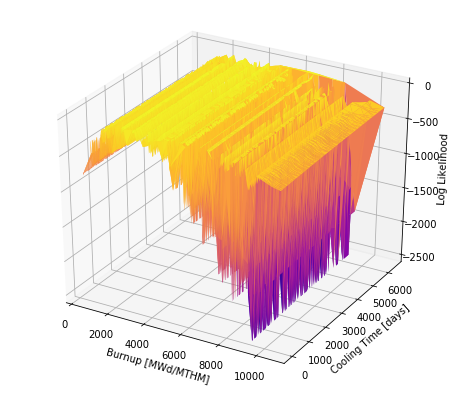

In [14]:
x = trainXY['Burnup']
y = trainXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = trainXY['LogLikelihood']

fig = plt.figure(figsize=(8, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(triang, z, linewidth=0.1, cmap=plt.cm.plasma)
#ax.scatter(x, y, z)
ax.set_xlabel('Burnup [MWd/MTHM]')
ax.set_ylabel('Cooling Time [days]')
ax.set_zlabel('Log Likelihood')
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [21]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)

In [22]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
X.shape

(12398, 16)

In [24]:
mod = NormMod(y, X)

In [25]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 2040419.517299
         Iterations: 5464
         Function evaluations: 7309
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -2.5297e+10
Model:                        NormMod   AIC:                         5.059e+10
Method:            Maximum Likelihood   BIC:                         5.059e+10
Date:                Tue, 20 Aug 2019                                         
Time:                        13:00:39                                         
No. Observations:               12398                                         
Df Residuals:                   12382                                         
Df Model:                          15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------